### Описание датасета

Данный датасет содержит информацию о клиентах банка. Основные характеристики:

- **RowNumber** — номер строки  
- **CustomerId** — уникальный идентификатор клиента  
- **Surname** — фамилия клиента  
- **CreditScore** — кредитный рейтинг  
- **Geography** — страна проживания  
- **Gender** — пол  
- **Age** — возраст  
- **Tenure** — сколько лет клиент пользуется услугами банка  
- **Balance** — баланс на счёте  
- **NumOfProducts** — количество банковских продуктов  
- **HasCrCard** — наличие кредитной карты  
- **IsActiveMember** — активность клиента  
- **EstimatedSalary** — предполагаемая зарплата  
- **Exited** — ушёл ли клиент из банка (**целевая переменная**)

> **Цель**: байесовская сеть для анализа факторов, влияющих на уход клиентов из банка.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict

### 0 Загрузка данных

In [59]:
data = pd.read_csv('Churn_Modelling.csv')

print("Первые 5 строк датасета:")
print(data.head())

print("\nИнформация о датасете:")
print(data.info())

Первые 5 строк датасета:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.6

### 1 Подготовка данных и создание бинарных признаков

In [60]:
# Берем 5 признаков для оценки
selected_features = ['Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'Exited']
df_selected = data[selected_features].copy()

df_selected['Age_Group'] = np.where(df_selected['Age'] <= 40, 'Young', 'Senior')
df_selected['Balance_Group'] = np.where(df_selected['Balance'] < 50000, 'Low', 'High')
df_selected['Products_Group'] = np.where(df_selected['NumOfProducts'] <= 2, 'Few', 'Many')
df_selected['Exited'] = df_selected['Exited'].map({0: 'Stayed', 1: 'Exited'})

df_final = df_selected[['Geography', 'Gender', 'Age_Group', 'Balance_Group', 'Products_Group', 'Exited']].copy()

print("Преобразованные данные:")
print(df_final.head())
print(f"\nРазмер датасета: {df_final.shape}")

Преобразованные данные:
  Geography  Gender Age_Group Balance_Group Products_Group  Exited
0    France  Female    Senior           Low            Few  Exited
1     Spain  Female    Senior          High            Few  Stayed
2    France  Female    Senior          High           Many  Exited
3    France  Female     Young           Low            Few  Stayed
4     Spain  Female    Senior          High            Few  Stayed

Размер датасета: (10000, 6)


### 2 Описание ожидаемых зависимостей

На основе предметной области ожидаем следующие зависимости:

1. **Geography → Exited**  
   Клиенты из разных стран могут демонстрировать различную склонность к уходу из банка из-за культурных, экономических и ... факторов.

2. **Age_Group → Exited**  
   Старшие клиенты, как правило, реже меняют банк, ибо им пофиг.

3. **Balance_Group → Exited**  
   Клиенты с высоким балансом могут быть либо более лояльными, либо менее лояльными - тут не угадаешь конечно

4. **Gender → Exited**  
   Пол может косвенно влиять на поведение клиента,

5. **Products_Group → Exited**  
   Чем больше банковских продуктов использует клиент, тем больше у него будут ожидание от другого банка, и, следовательно, тем ниже вероятность ухода

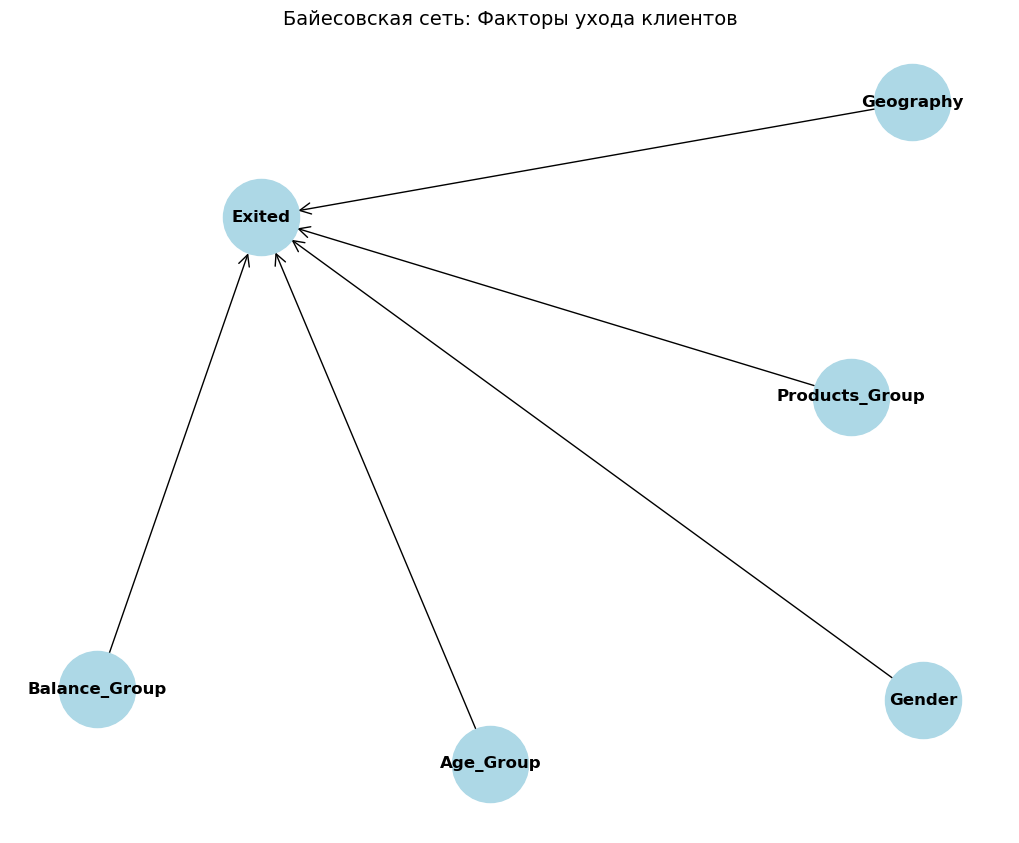

In [61]:
G = nx.DiGraph()

nodes = ['Geography', 'Gender', 'Age_Group', 'Balance_Group', 'Products_Group', 'Exited']
G.add_nodes_from(nodes)

edges = [
    ('Geography', 'Exited'),
    ('Gender', 'Exited'), 
    ('Age_Group', 'Exited'),
    ('Balance_Group', 'Exited'),
    ('Products_Group', 'Exited')
]
G.add_edges_from(edges)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', 
        font_size=12, font_weight='bold', arrowsize=20, arrowstyle='->')
plt.title('Байесовская сеть: Факторы ухода клиентов', size=14)
plt.show()

### 3 Расчет условных вероятностей

In [62]:
def calculate_cpt(data, child, parents, alpha=1):
    groups = data.groupby(parents + [child]).size().reset_index(name='count')
    
    parent_counts = data.groupby(parents).size().reset_index(name='parent_total')
    
    cpt = pd.merge(groups, parent_counts, on=parents)
    
    n_child_values = len(data[child].unique())
    
    cpt['probability'] = (cpt['count'] + alpha) / (cpt['parent_total'] + alpha * n_child_values)
    
    return cpt[parents + [child, 'probability']]

#### 3.1 Расчет CPT для целевой переменной Exited

In [63]:
print("Условные вероятности для Exited (с лапласовским сглаживанием):")
cpt_exited = calculate_cpt(df_final, 'Exited', ['Geography', 'Age_Group'])
print(cpt_exited)

Условные вероятности для Exited (с лапласовским сглаживанием):
   Geography Age_Group  Exited  probability
0     France    Senior  Exited     0.323935
1     France    Senior  Stayed     0.676065
2     France     Young  Exited     0.081170
3     France     Young  Stayed     0.918830
4    Germany    Senior  Exited     0.526062
5    Germany    Senior  Stayed     0.473938
6    Germany     Young  Exited     0.183480
7    Germany     Young  Stayed     0.816520
8      Spain    Senior  Exited     0.304299
9      Spain    Senior  Stayed     0.695701
10     Spain     Young  Exited     0.091421
11     Spain     Young  Stayed     0.908579


#### 3.2 CPT для других комбинаций

In [64]:
print("\nУсловные вероятности Exited по Geography и Gender:")
cpt_geo_gender = calculate_cpt(df_final, 'Exited', ['Geography', 'Gender'])
print(cpt_geo_gender)

print("\nУсловные вероятности Exited по Age_Group и Balance_Group:")
cpt_age_balance = calculate_cpt(df_final, 'Exited', ['Age_Group', 'Balance_Group'])
print(cpt_age_balance)



Условные вероятности Exited по Geography и Gender:
   Geography  Gender  Exited  probability
0     France  Female  Exited     0.203712
1     France  Female  Stayed     0.796288
2     France    Male  Exited     0.127405
3     France    Male  Stayed     0.872595
4    Germany  Female  Exited     0.375732
5    Germany  Female  Stayed     0.624268
6    Germany    Male  Exited     0.278452
7    Germany    Male  Stayed     0.721548
8      Spain  Female  Exited     0.212649
9      Spain  Female  Stayed     0.787351
10     Spain    Male  Exited     0.131655
11     Spain    Male  Stayed     0.868345

Условные вероятности Exited по Age_Group и Balance_Group:
  Age_Group Balance_Group  Exited  probability
0    Senior          High  Exited     0.425532
1    Senior          High  Stayed     0.574468
2    Senior           Low  Exited     0.285830
3    Senior           Low  Stayed     0.714170
4     Young          High  Exited     0.129480
5     Young          High  Stayed     0.870520
6     Young   

### 4 Вычисление условных вероятностей

In [65]:
def conditional_probability(data, target, given):
    filtered_data = data
    for key, value in given.items():
        filtered_data = filtered_data[filtered_data[key] == value]
    
    if len(filtered_data) == 0:
        return 0
    
    target_count = len(filtered_data[filtered_data[target] == list(filtered_data[target].unique())[0]])
    total_count = len(filtered_data)
    
    return target_count / total_count

In [66]:
# P(Exited|Senior)
prob_senior = conditional_probability(df_final, 'Exited', {'Age_Group': 'Senior'})
print(f"P(Exited|Senior) = {prob_senior:.3f}")

# P(Exited|Young)
prob_young = conditional_probability(df_final, 'Exited', {'Age_Group': 'Young'})
print(f"P(Exited|Young) = {prob_young:.3f}")

# P(Exited|Senior, Germany)
prob_senior_germany = conditional_probability(df_final, 'Exited', {'Age_Group': 'Senior', 'Geography': 'Germany'})
print(f"P(Exited|Senior, Germany) = {prob_senior_germany:.3f}")

# P(Exited|High Balance, Many Products)
prob_rich_many = conditional_probability(df_final, 'Exited', {'Balance_Group': 'High', 'Products_Group': 'Many'})
print(f"P(Exited|High Balance, Many Products) = {prob_rich_many:.3f}")


P(Exited|Senior) = 0.377
P(Exited|Young) = 0.893
P(Exited|Senior, Germany) = 0.474
P(Exited|High Balance, Many Products) = 0.957


#### 4.1 Анализ маргинальных вероятностей

In [67]:
print("Маргинальные вероятности:")
print(f"P(Exited) = {len(df_final[df_final['Exited'] == 'Exited']) / len(df_final):.3f}")
print(f"P(Senior) = {len(df_final[df_final['Age_Group'] == 'Senior']) / len(df_final):.3f}")
print(f"P(High Balance) = {len(df_final[df_final['Balance_Group'] == 'High']) / len(df_final):.3f}")
print(f"P(Germany) = {len(df_final[df_final['Geography'] == 'Germany']) / len(df_final):.3f}")

Маргинальные вероятности:
P(Exited) = 0.204
P(Senior) = 0.358
P(High Balance) = 0.631
P(Germany) = 0.251


### 5 Визуализация вероятностей

#### 5.1 Вероятность ухода по странам

(array([0, 1, 2]),
 [Text(0, 0, 'France'), Text(1, 0, 'Germany'), Text(2, 0, 'Spain')])

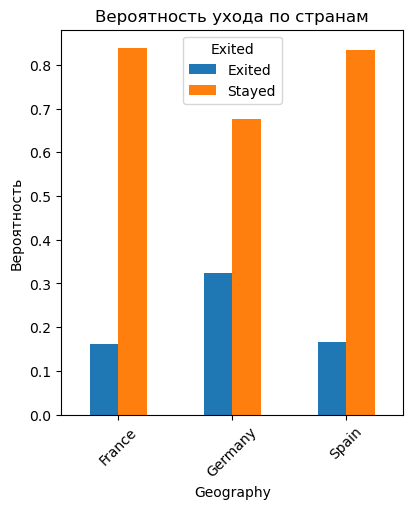

In [68]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
geo_probs = df_final.groupby('Geography')['Exited'].value_counts(normalize=True).unstack()
geo_probs.plot(kind='bar', ax=plt.gca())
plt.title('Вероятность ухода по странам')
plt.ylabel('Вероятность')
plt.xticks(rotation=45)

#### 5.2 Вероятность ухода по возрастным группам

(array([0, 1]), [Text(0, 0, 'Senior'), Text(1, 0, 'Young')])

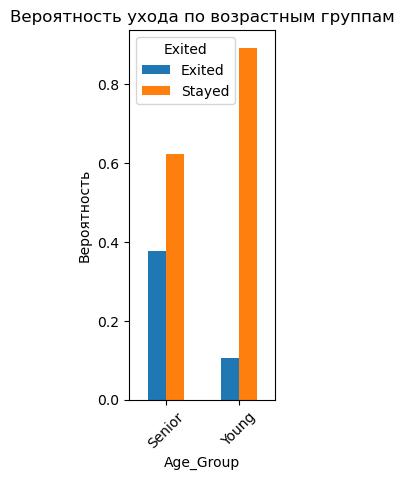

In [69]:
plt.subplot(1, 3, 2)
age_probs = df_final.groupby('Age_Group')['Exited'].value_counts(normalize=True).unstack()
age_probs.plot(kind='bar', ax=plt.gca())
plt.title('Вероятность ухода по возрастным группам')
plt.ylabel('Вероятность')
plt.xticks(rotation=45)

#### 5.3 Вероятность ухода по балансу

(array([0, 1]), [Text(0, 0, 'High'), Text(1, 0, 'Low')])

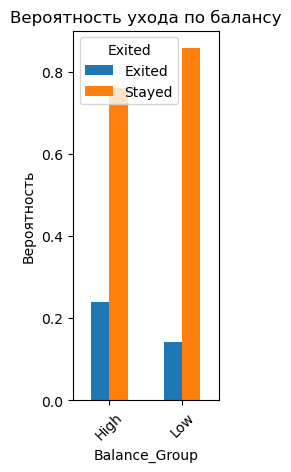

In [70]:
plt.subplot(1, 3, 3)
balance_probs = df_final.groupby('Balance_Group')['Exited'].value_counts(normalize=True).unstack()
balance_probs.plot(kind='bar', ax=plt.gca())
plt.title('Вероятность ухода по балансу')
plt.ylabel('Вероятность')
plt.xticks(rotation=45)

### Вывод

### 1. Возрастной фактор
- **P(Exited | Senior) = 0.377** vs **P(Exited | Young) = 0.089**  
- **Статистика**: Старшие клиенты уходят в **4.2 раза чаще**  
- **Вывод**: Возраст — самый сильный предиктор ухода клиентов

### 2. Географические особенности
- **Германия**: максимальный риск ухода, особенно среди старших клиентов  
- **Франция и Испания**: сравнительно низкие показатели оттока  
- **P(Exited | Germany, Senior) = 0.526** — критическая группа риска

### 3. Влияние баланса
- Клиенты с высоким балансом уходят чаще (**0.426** против **0.285** у старших с низким балансом)  
- Вероятно, клиенты с большими средствами более требовательны к качеству обслуживания

### 4. Гендерные различия
- Женщины уходят чаще мужчин во всех странах  
- В Германии: **37.6 %** женщин против **27.8 %** мужчин

### 5. Продуктовая лояльность
- **P(Exited | High Balance, Many Products) = 0.957**  
- **Парадокс**: клиенты с большим количеством продуктов демонстрируют **повышенный риск ухода**  
- Возможно, это недовольные крутые типы, ожидающие персонализированного подхода